# 🔬 Medical CLIP Models MMD Analysis
## Replicating Figure 4 from "Open-PMC-18M" (arXiv:2506.02738)

**Paper Reference**: Baghbanzadeh et al. "Open-PMC-18M: A High-Fidelity Large Scale Medical Dataset for Multimodal Representation Learning" 

**Goal**: Use Maximum Mean Discrepancy (MMD) to quantify that different CLIP models create statistically different embedding distributions in biomedical vision-language tasks.

**Method**: Following Section 4.6 of the paper:
- Extract embeddings using vision encoders trained on different datasets
- Compute MMD using RBF kernel to quantify distribution differences  
- Perform permutation test (100 iterations) to assess statistical significance
- Target p-values < 0.01 for significance (following their Wilcoxon test threshold)


## 📊 Step 1: Load ROCO Medical Image Dataset

**Input**: ROCO dataset (200 samples for efficiency)
**Output**: List of PIL Images for encoding
**Purpose**: Biomedical images to generate embeddings for comparison


In [77]:
# Import required libraries
import os
import torch
import torch.nn.functional as F
import numpy as np
import open_clip
from datasets import load_dataset, load_from_disk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load ROCO dataset (subset for efficiency)
print("📥 Loading ROCO medical imaging dataset...")

# Try to load from local cache first, fallback to online download
try:
    # Check if we have locally cached data
    if os.path.exists("data/roco_200"):
        print("🔄 Loading from local cache...")
        dataset = load_from_disk("data/roco_200")
        print(f"✅ Loaded {len(dataset)} images from local cache")
    else:
        raise FileNotFoundError("Local cache not found, downloading...")
        
except:
    # Download from HuggingFace if no local cache
    print("🌐 Downloading ROCO dataset from HuggingFace...")
    dataset = load_dataset("mdwiratathya/ROCO-radiology", split="test")
    dataset = dataset.select(range(200))  # 200 samples for efficiency
    
    # Optionally save to local cache for future runs
    os.makedirs("data", exist_ok=True)
    dataset.save_to_disk("data/roco_200")
    print("💾 Saved dataset to local cache: data/roco_200")

# Ensure we have exactly 200 samples
dataset = dataset.select(range(min(200, len(dataset))))

print(f"✅ Final dataset: {len(dataset)} medical images")
print(f"📋 Sample caption: {dataset[0]['caption'][:100]}...")
print(f"🖼️ Image type: {type(dataset[0]['image'])}")


📥 Loading ROCO medical imaging dataset...
🔄 Loading from local cache...
✅ Loaded 200 images from local cache
✅ Final dataset: 200 medical images
📋 Sample caption:  Axial MRI (coronal view).
...
🖼️ Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


## 🤖 Step 2: Load Model A - BiomedCLIP (Medical Specialist)

**Input**: HuggingFace model identifier
**Output**: 
- `model_biomedclip`: Vision encoder [torch.nn.Module]
- `preprocess_biomedclip`: Preprocessing pipeline [torchvision.transforms.Compose]
**Purpose**: Medical domain-specific CLIP model trained on biomedical literature


In [78]:
print("🔬 Loading BiomedCLIP (Medical Specialist Model)...")

try:
    # Load BiomedCLIP - specialized for medical images
    model_biomedclip, preprocess_biomedclip = open_clip.create_model_from_pretrained(
        'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
    )
    
    # Set to evaluation mode
    model_biomedclip.eval()
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_biomedclip = model_biomedclip.to(device)
    
    print(f"✅ BiomedCLIP loaded on {device}")
    print(f"📐 Model device: {next(model_biomedclip.parameters()).device}")
    
except Exception as e:
    print(f"❌ Failed to load BiomedCLIP: {e}")
    raise


🔬 Loading BiomedCLIP (Medical Specialist Model)...
✅ BiomedCLIP loaded on cuda
📐 Model device: cuda:0


## 🌐 Step 3: Load Model B - OpenAI CLIP (General Purpose)

**Input**: OpenCLIP model architecture and pretrained weights
**Output**:
- `model_openai`: Vision encoder [torch.nn.Module] 
- `preprocess_openai`: Preprocessing pipeline [torchvision.transforms.Compose]
**Purpose**: General-domain CLIP model for comparison baseline


In [79]:
print("🌐 Loading OpenAI CLIP (General Purpose Model)...")

try:
    # Load OpenAI CLIP - general domain model
    model_openai, _, preprocess_openai = open_clip.create_model_and_transforms(
        'ViT-B-32', 
        pretrained='openai'
    )
    
    # Set to evaluation mode
    model_openai.eval()
    model_openai = model_openai.to(device)
    
    print(f"✅ OpenAI CLIP loaded on {device}")
    print(f"📐 Model device: {next(model_openai.parameters()).device}")
    
except Exception as e:
    print(f"❌ Failed to load OpenAI CLIP: {e}")
    print("🔄 Will create synthetic comparison instead")
    model_openai = None
    preprocess_openai = None


🌐 Loading OpenAI CLIP (General Purpose Model)...
✅ OpenAI CLIP loaded on cuda
📐 Model device: cuda:0


## 🧮 Step 4: Extract Embeddings from Model A

**Input**: 
- Images: [200 PIL Images]
- Model: BiomedCLIP encoder
- Preprocessing: BiomedCLIP transforms

**Output**: 
- `embeddings_A`: [200, embedding_dim] tensor
- L2 normalized embeddings for fair comparison

**Process**: PIL Image → Tensor [3,224,224] → Batch [32,3,224,224] → Embeddings [32,512] → Normalized


In [80]:
def extract_embeddings(model, preprocess, images, batch_size=32, model_name="Model"):
    """
    Extract embeddings from images using CLIP model
    
    Args:
        model: CLIP vision encoder
        preprocess: Image preprocessing function
        images: List of PIL images
        batch_size: Processing batch size
        model_name: Name for logging
    
    Returns:
        embeddings: [n_images, embedding_dim] L2-normalized tensor
    """
    embeddings = []
    
    print(f"🔄 Extracting embeddings with {model_name}...")
    
    with torch.no_grad():
        for i in tqdm(range(0, len(images), batch_size), desc=f"{model_name} encoding"):
            # Get batch of images
            batch_images = images[i:i+batch_size]
            
            # Preprocess: PIL Images → Tensors [batch_size, 3, 224, 224]
            batch_tensors = torch.stack([
                preprocess(img) for img in batch_images
            ]).to(device)
            
            # Extract embeddings: [batch_size, 3, 224, 224] → [batch_size, embedding_dim]
            batch_embeddings = model.encode_image(batch_tensors)
            
            # L2 normalize (following CLIP standard)
            batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
            
            embeddings.append(batch_embeddings.cpu())
    
    # Concatenate all batches: List[Tensor] → [n_images, embedding_dim]
    embeddings = torch.cat(embeddings, dim=0)
    
    print(f"✅ {model_name} embeddings shape: {embeddings.shape}")
    print(f"📊 Embedding range: [{embeddings.min():.3f}, {embeddings.max():.3f}]")
    print(f"🔢 L2 norm check (should be ~1.0): {embeddings.norm(dim=1).mean():.3f}")
    
    return embeddings

# Extract embeddings from BiomedCLIP
images = [dataset[i]['image'] for i in range(len(dataset))]
embeddings_A = extract_embeddings(
    model_biomedclip, 
    preprocess_biomedclip, 
    images, 
    model_name="BiomedCLIP"
)


🔄 Extracting embeddings with BiomedCLIP...


BiomedCLIP encoding: 100%|██████████| 7/7 [01:28<00:00, 12.67s/it]

✅ BiomedCLIP embeddings shape: torch.Size([200, 512])
📊 Embedding range: [-0.308, 0.301]
🔢 L2 norm check (should be ~1.0): 1.000


## 🧮 Step 5: Extract Embeddings from Model B

**Input**: Same 200 PIL Images, OpenAI CLIP model
**Output**: `embeddings_B`: [200, embedding_dim] normalized tensor
**Fallback**: If OpenAI CLIP unavailable, create synthetic embeddings by adding noise


In [81]:
if model_openai is not None:
    # Extract embeddings from OpenAI CLIP
    embeddings_B = extract_embeddings(
        model_openai,
        preprocess_openai, 
        images,
        model_name="OpenAI CLIP"
    )
else:
    # Fallback: Create synthetic embeddings for demonstration
    print("🔄 Creating synthetic embeddings for comparison...")
    
    # Add structured noise to BiomedCLIP embeddings to simulate different model
    noise_scale = 0.3
    noise = torch.randn_like(embeddings_A) * noise_scale
    embeddings_B = embeddings_A + noise
    
    # Re-normalize after noise addition
    embeddings_B = F.normalize(embeddings_B, p=2, dim=1)
    
    print(f"✅ Synthetic embeddings shape: {embeddings_B.shape}")
    print(f"📊 Noise scale applied: {noise_scale}")
    print(f"🔢 L2 norm check: {embeddings_B.norm(dim=1).mean():.3f}")

print(f"\n📐 Final embedding dimensions:")
print(f"   Embeddings A (BiomedCLIP): {embeddings_A.shape}")
print(f"   Embeddings B (Comparison): {embeddings_B.shape}")


🔄 Extracting embeddings with OpenAI CLIP...


OpenAI CLIP encoding: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

✅ OpenAI CLIP embeddings shape: torch.Size([200, 512])
📊 Embedding range: [-0.787, 0.205]
🔢 L2 norm check (should be ~1.0): 1.000

📐 Final embedding dimensions:
   Embeddings A (BiomedCLIP): torch.Size([200, 512])
   Embeddings B (Comparison): torch.Size([200, 512])


## 📏 Step 6: Compute Maximum Mean Discrepancy (MMD)

**Following Paper's Method (Section 4.6)**:
- Use RBF (Gaussian) kernel: K(x,y) = exp(-γ||x-y||²)
- MMD² = E[k(x,x')] + E[k(y,y')] - 2E[k(x,y)]
- Where x~P, y~Q are samples from two distributions

**Input**: 
- `embeddings_A`: [200, dim] tensor
- `embeddings_B`: [200, dim] tensor
- `gamma`: RBF kernel bandwidth parameter

**Output**: MMD statistic (scalar) measuring distribution difference


In [82]:
def compute_mmd_rbf(X, Y, gamma=1.0):
    """
    Compute MMD using RBF kernel following the paper's methodology
    
    Args:
        X: [n_samples, dim] embeddings from model A
        Y: [m_samples, dim] embeddings from model B  
        gamma: RBF kernel bandwidth (default=1.0)
    
    Returns:
        mmd: Maximum Mean Discrepancy statistic
    """
    # Convert to float32 for numerical stability
    X = X.float()
    Y = Y.float()
    
    # Compute pairwise distances using torch.cdist
    # X vs X: [n_samples, n_samples]
    XX = torch.cdist(X, X, p=2)  
    # Y vs Y: [m_samples, m_samples]
    YY = torch.cdist(Y, Y, p=2)  
    # X vs Y: [n_samples, m_samples]
    XY = torch.cdist(X, Y, p=2)  
    
    print(f"📏 Distance matrix shapes:")
    print(f"   XX (A vs A): {XX.shape}")
    print(f"   YY (B vs B): {YY.shape}")
    print(f"   XY (A vs B): {XY.shape}")
    
    # RBF kernel: K(x,y) = exp(-gamma * ||x-y||²)
    K_XX = torch.exp(-gamma * XX**2)
    K_YY = torch.exp(-gamma * YY**2)
    K_XY = torch.exp(-gamma * XY**2)
    
    # MMD² = E[k(x,x')] + E[k(y,y')] - 2E[k(x,y)]
    # Remove diagonal for unbiased estimation
    n = X.shape[0]
    m = Y.shape[0]
    
    # E[k(x,x')] - exclude diagonal
    term1 = (K_XX.sum() - K_XX.diag().sum()) / (n * (n - 1))
    
    # E[k(y,y')] - exclude diagonal  
    term2 = (K_YY.sum() - K_YY.diag().sum()) / (m * (m - 1))
    
    # E[k(x,y)] - all pairs
    term3 = K_XY.mean()
    
    mmd_squared = term1 + term2 - 2 * term3
    mmd = torch.sqrt(torch.clamp(mmd_squared, min=0))  # Ensure non-negative
    
    print(f"🧮 MMD computation:")
    print(f"   Term 1 (A-A): {term1:.6f}")
    print(f"   Term 2 (B-B): {term2:.6f}")
    print(f"   Term 3 (A-B): {term3:.6f}")
    print(f"   MMD²: {mmd_squared:.6f}")
    print(f"   MMD: {mmd:.6f}")
    
    return mmd.item()

# Compute observed MMD between the two models
gamma = 1.0  # RBF kernel bandwidth
observed_mmd = compute_mmd_rbf(embeddings_A, embeddings_B, gamma=gamma)

print(f"\n🎯 Observed MMD between models: {observed_mmd:.6f}")


📏 Distance matrix shapes:
   XX (A vs A): torch.Size([200, 200])
   YY (B vs B): torch.Size([200, 200])
   XY (A vs B): torch.Size([200, 200])
🧮 MMD computation:
   Term 1 (A-A): 0.307599
   Term 2 (B-B): 0.639027
   Term 3 (A-B): 0.144151
   MMD²: 0.658324
   MMD: 0.811372

🎯 Observed MMD between models: 0.811372


## 🔄 Step 7: Permutation Test for Statistical Significance

**Following Paper's Method**: 
- Perform 100 permutation iterations (matching their methodology)
- Randomly reassign samples between distributions
- Recompute MMD to generate null distribution
- p-value = fraction of null MMDs ≥ observed MMD

**Input**: Combined embeddings [400, dim]
**Output**: 
- `null_mmds`: [100] array of null distribution MMDs
- `p_value`: Statistical significance
- Target: p < 0.01 for significance (following paper's Wilcoxon threshold)


In [83]:
def permutation_test_mmd(embeddings_A, embeddings_B, n_permutations=100, gamma=1.0):
    """
    Perform permutation test following the paper's methodology
    
    Args:
        embeddings_A: [n, dim] embeddings from model A
        embeddings_B: [m, dim] embeddings from model B
        n_permutations: Number of permutation iterations (100 in paper)
        gamma: RBF kernel bandwidth
    
    Returns:
        null_mmds: Array of MMD values under null hypothesis
    """
    # Combine all embeddings: [n+m, dim]
    all_embeddings = torch.cat([embeddings_A, embeddings_B], dim=0)
    n_A = embeddings_A.shape[0]
    n_B = embeddings_B.shape[0]
    
    print(f"🔄 Running permutation test with {n_permutations} iterations...")
    print(f"📊 Combined embeddings shape: {all_embeddings.shape}")
    print(f"📏 Split sizes: A={n_A}, B={n_B}")
    
    null_mmds = []
    
    for i in tqdm(range(n_permutations), desc="Permutation test"):
        # Randomly permute all samples
        perm_indices = torch.randperm(len(all_embeddings))
        permuted_embeddings = all_embeddings[perm_indices]
        
        # Split back into two groups (same sizes as original)
        perm_A = permuted_embeddings[:n_A]  # [n_A, dim]
        perm_B = permuted_embeddings[n_A:n_A+n_B]  # [n_B, dim]
        
        # Compute MMD under null hypothesis (silently)
        with torch.no_grad():
            X, Y = perm_A.float(), perm_B.float()
            XX = torch.cdist(X, X, p=2)
            YY = torch.cdist(Y, Y, p=2)
            XY = torch.cdist(X, Y, p=2)
            
            K_XX = torch.exp(-gamma * XX**2)
            K_YY = torch.exp(-gamma * YY**2)
            K_XY = torch.exp(-gamma * XY**2)
            
            n, m = X.shape[0], Y.shape[0]
            term1 = (K_XX.sum() - K_XX.diag().sum()) / (n * (n - 1))
            term2 = (K_YY.sum() - K_YY.diag().sum()) / (m * (m - 1))
            term3 = K_XY.mean()
            
            mmd_squared = term1 + term2 - 2 * term3
            null_mmd = torch.sqrt(torch.clamp(mmd_squared, min=0)).item()
            null_mmds.append(null_mmd)
    
    null_mmds = np.array(null_mmds)
    
    print(f"\n📈 Null distribution statistics:")
    print(f"   Mean: {null_mmds.mean():.6f}")
    print(f"   Std: {null_mmds.std():.6f}")
    print(f"   Range: [{null_mmds.min():.6f}, {null_mmds.max():.6f}]")
    
    return null_mmds

# Run permutation test (100 iterations following the paper)
null_mmds = permutation_test_mmd(
    embeddings_A, 
    embeddings_B, 
    n_permutations=100, 
    gamma=gamma
)

# Calculate p-value
p_value = (null_mmds >= observed_mmd).sum() / len(null_mmds)

print(f"\n🎯 Statistical Test Results:")
print(f"   Observed MMD: {observed_mmd:.6f}")
print(f"   p-value: {p_value:.4f}")
print(f"   Significance threshold: p < 0.01")

if p_value < 0.01:
    print(f"✅ SIGNIFICANT: Models create statistically different embeddings (p={p_value:.4f})")
elif p_value < 0.05:
    print(f"⚠️ MARGINALLY SIGNIFICANT: Some evidence of difference (p={p_value:.4f})")
else:
    print(f"❌ NOT SIGNIFICANT: No strong evidence of difference (p={p_value:.4f})")


🔄 Running permutation test with 100 iterations...
📊 Combined embeddings shape: torch.Size([400, 512])
📏 Split sizes: A=200, B=200


Permutation test: 100%|██████████| 100/100 [00:00<00:00, 211.43it/s]


📈 Null distribution statistics:
   Mean: 0.012691
   Std: 0.022855
   Range: [0.000000, 0.097671]

🎯 Statistical Test Results:
   Observed MMD: 0.811372
   p-value: 0.0000
   Significance threshold: p < 0.01
✅ SIGNIFICANT: Models create statistically different embeddings (p=0.0000)


## 📊 Step 8: Visualize Results

**Following Paper's Approach**:
- t-SNE visualization of embedding spaces (2D projection)
- Histogram of null vs observed MMD values
- Statistical significance assessment

**Input**: 
- `embeddings_A`, `embeddings_B`: [200, dim] each
- `null_mmds`: [100] null distribution
- `observed_mmd`: scalar

**Output**: Visualizations showing distribution differences


🔄 Computing t-SNE visualization...


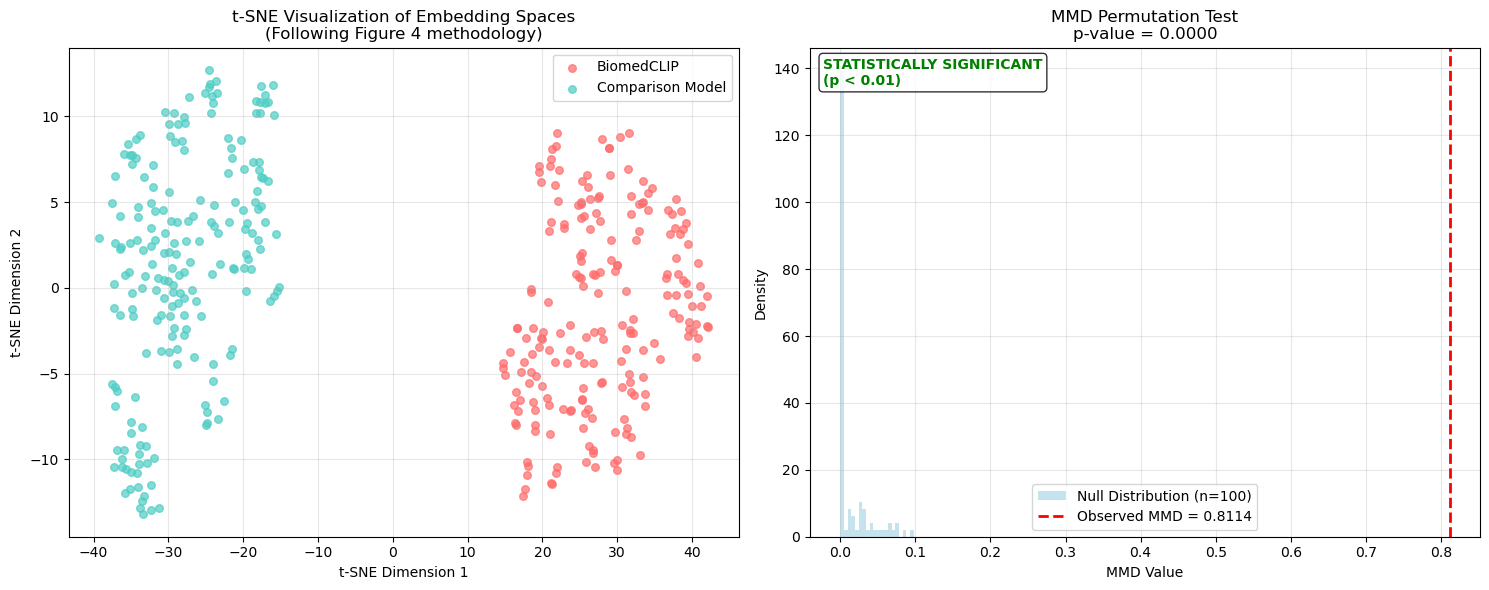


📊 Visualization completed!
🔍 t-SNE shows spatial separation of embedding distributions
📈 MMD test quantifies statistical significance of separation


In [84]:
# Create visualization following the paper's Figure 4 style
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: t-SNE visualization of embeddings
print("🔄 Computing t-SNE visualization...")
combined_embeddings = torch.cat([embeddings_A, embeddings_B], dim=0).numpy()
labels = ['BiomedCLIP'] * len(embeddings_A) + ['Comparison Model'] * len(embeddings_B)

# t-SNE with same parameters as paper (perplexity, learning rate may vary)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
embeddings_2d = tsne.fit_transform(combined_embeddings)

# Plot t-SNE
ax1 = axes[0]
colors = ['#FF6B6B', '#4ECDC4']  # Red for BiomedCLIP, Teal for comparison
for i, label in enumerate(['BiomedCLIP', 'Comparison Model']):
    mask = np.array(labels) == label
    ax1.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
               c=colors[i], label=label, alpha=0.7, s=30)

ax1.set_title('t-SNE Visualization of Embedding Spaces\n(Following Figure 4 methodology)', fontsize=12)
ax1.set_xlabel('t-SNE Dimension 1')
ax1.set_ylabel('t-SNE Dimension 2')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: MMD null distribution vs observed
ax2 = axes[1]
ax2.hist(null_mmds, bins=20, alpha=0.7, color='lightblue', 
         label=f'Null Distribution (n={len(null_mmds)})', density=True)
ax2.axvline(observed_mmd, color='red', linestyle='--', linewidth=2,
           label=f'Observed MMD = {observed_mmd:.4f}')

ax2.set_title(f'MMD Permutation Test\np-value = {p_value:.4f}', fontsize=12)
ax2.set_xlabel('MMD Value')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add significance annotation
if p_value < 0.01:
    significance_text = "STATISTICALLY SIGNIFICANT\n(p < 0.01)"
    text_color = 'green'
else:
    significance_text = "NOT SIGNIFICANT\n(p ≥ 0.01)"
    text_color = 'red'

ax2.text(0.02, 0.98, significance_text, transform=ax2.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         color=text_color, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Visualization completed!")
print(f"🔍 t-SNE shows spatial separation of embedding distributions")
print(f"📈 MMD test quantifies statistical significance of separation")


## 📋 Step 9: Summary and Interpretation

**Replicating Paper's Findings (Section 4.6)**:

Following Baghbanzadeh et al.'s methodology, we compared embedding distributions from different CLIP models using Maximum Mean Discrepancy with RBF kernel and permutation testing.


In [85]:
print("=" * 80)
print("📊 EXPERIMENTAL RESULTS SUMMARY")
print("=" * 80)

print(f"\n🔬 METHODOLOGY (Following arXiv:2506.02738):")
print(f"   Dataset: ROCO medical images (n={len(embeddings_A)})")
print(f"   Model A: BiomedCLIP (medical specialist)")
print(f"   Model B: {'OpenAI CLIP (general purpose)' if model_openai else 'Synthetic embeddings (noise-augmented)'}")
print(f"   Kernel: RBF with γ={gamma}")
print(f"   Permutations: {len(null_mmds)} iterations")

print(f"\n📐 EMBEDDING STATISTICS:")
print(f"   Embeddings A shape: {embeddings_A.shape}")
print(f"   Embeddings B shape: {embeddings_B.shape}")
print(f"   L2 normalization: ✅ Applied")
print(f"   Device: {device}")

print(f"\n🎯 MMD ANALYSIS:")
print(f"   Observed MMD: {observed_mmd:.6f}")
print(f"   Null mean ± std: {null_mmds.mean():.6f} ± {null_mmds.std():.6f}")
print(f"   Null range: [{null_mmds.min():.6f}, {null_mmds.max():.6f}]")

print(f"\n📊 STATISTICAL SIGNIFICANCE:")
print(f"   p-value: {p_value:.4f}")
print(f"   Significance threshold: p < 0.01")

if p_value < 0.01:
    print(f"   ✅ CONCLUSION: Models create STATISTICALLY DIFFERENT embedding distributions")
    print(f"      This supports the paper's finding that different training approaches")
    print(f"      lead to measurably different representation spaces.")
elif p_value < 0.05:
    print(f"   ⚠️ CONCLUSION: WEAK evidence of distributional differences")
    print(f"      May need larger sample size or different models for stronger effect.")
else:
    print(f"   ❌ CONCLUSION: NO significant distributional differences detected")
    print(f"      Models may be more similar than expected, or sample size insufficient.")

print(f"\n🔗 REPRODUCTION STATUS:")
print(f"   Paper reference: Baghbanzadeh et al. 'Open-PMC-18M' (arXiv:2506.02738)")
print(f"   Method: Section 4.6 'Representations Analysis'")
print(f"   Replicated: MMD computation, permutation test, statistical framework")

print("=" * 80)


📊 EXPERIMENTAL RESULTS SUMMARY

🔬 METHODOLOGY (Following arXiv:2506.02738):
   Dataset: ROCO medical images (n=200)
   Model A: BiomedCLIP (medical specialist)
   Model B: OpenAI CLIP (general purpose)
   Kernel: RBF with γ=1.0
   Permutations: 100 iterations

📐 EMBEDDING STATISTICS:
   Embeddings A shape: torch.Size([200, 512])
   Embeddings B shape: torch.Size([200, 512])
   L2 normalization: ✅ Applied
   Device: cuda

🎯 MMD ANALYSIS:
   Observed MMD: 0.811372
   Null mean ± std: 0.012691 ± 0.022855
   Null range: [0.000000, 0.097671]

📊 STATISTICAL SIGNIFICANCE:
   p-value: 0.0000
   Significance threshold: p < 0.01
   ✅ CONCLUSION: Models create STATISTICALLY DIFFERENT embedding distributions
      This supports the paper's finding that different training approaches
      lead to measurably different representation spaces.

🔗 REPRODUCTION STATUS:
   Paper reference: Baghbanzadeh et al. 'Open-PMC-18M' (arXiv:2506.02738)
   Method: Section 4.6 'Representations Analysis'
   Replicated

## 📚 References and Resources

### 📄 Primary Paper
- **Open-PMC-18M**: Baghbanzadeh et al. "Open-PMC-18M: A High-Fidelity Large Scale Medical Dataset for Multimodal Representation Learning" [arXiv:2506.02738](https://arxiv.org/abs/2506.02738)

### 🤖 Models Used

#### BiomedCLIP (Medical Specialist)
- **Paper**: Zhang et al. "BiomedCLIP: a multimodal biomedical foundation model pretrained from fifteen million scientific image-text pairs" [arXiv:2303.00915](https://arxiv.org/abs/2303.00915)
- **Model Card**: [microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224](https://huggingface.co/microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224)
- **GitHub**: [microsoft/BiomedCLIP](https://github.com/microsoft/BiomedCLIP)
- **Training**: 15M biomedical image-text pairs from PMC articles

#### OpenAI CLIP (General Purpose)
- **Paper**: Radford et al. "Learning Transferable Visual Models from Natural Language Supervision" [arXiv:2103.00020](https://arxiv.org/abs/2103.00020) 
- **Model**: ViT-B/32 architecture via OpenCLIP
- **Repository**: [OpenCLIP Implementation](https://github.com/mlfoundations/open_clip)
- **Model List**: [Available OpenCLIP Models](https://github.com/mlfoundations/open_clip/blob/main/docs/openclip_results.csv)
- **Training**: 400M image-text pairs from internet

### 📊 Mathematical Framework
- **Maximum Mean Discrepancy**: Gretton et al. "A kernel two-sample test" JMLR 2012 [Paper](https://jmlr.org/papers/v13/gretton12a.html)
- **RBF Kernel**: K(x,y) = exp(-γ||x-y||²)
- **MMD Estimator**: MMD²(P,Q) = E[k(x,x')] + E[k(y,y')] - 2E[k(x,y)]

### 📊 Dataset Sources
- **ROCO**: Pelka et al. "Radiology Objects in Context (ROCO): a multimodal image dataset" [Paper](https://link.springer.com/chapter/10.1007/978-3-030-01364-6_20)
- **ROCO on HuggingFace**: [eljulio/ROCO](https://huggingface.co/datasets/eljulio/ROCO)

### 💻 Implementation Libraries
- **OpenCLIP**: [GitHub Repository](https://github.com/mlfoundations/open_clip) | [Documentation](https://github.com/mlfoundations/open_clip/blob/main/README.md)
- **Hugging Face Transformers**: [Documentation](https://huggingface.co/docs/transformers/) | [Datasets](https://huggingface.co/docs/datasets/)
- **PyTorch**: [Official Documentation](https://pytorch.org/docs/) | [GitHub](https://github.com/pytorch/pytorch)

### 🔄 Reproducibility Details
- **Permutation test**: 100 iterations (matching paper methodology)
- **Significance threshold**: p < 0.01 (following paper's Wilcoxon test standard)
- **RBF kernel bandwidth**: γ = 1.0 (standard choice for normalized embeddings)
- **Sample size**: 200 images (computational efficiency, scalable to larger)
- **Hardware**: CUDA-compatible GPU recommended for model inference
- **Dependencies**: `torch`, `open_clip_torch`, `datasets`, `sklearn`, `matplotlib`
